<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/protoMAML/prototypical%2BMAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN based ProtoNet + MAML

In [13]:
# ============================================================
# Few-shot AMR via Token-CNN ProtoNet
# (cosine+temp, RC augmentation, MAX_LEN=512, restrained dropout)
# ============================================================

# Cell 1: Imports, seeds, device
import os, random, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED); random.seed(RANDOM_SEED); torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
# Cell 2: Load & clean data
CSV_PATH = "megares_fasta_processed.csv"  # change if needed
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["sequence","mechanism"]).reset_index(drop=True)
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)
print("Dataset:", df.shape, " | unique mechanisms:", df["mechanism"].nunique())

Dataset: (8733, 9)  | unique mechanisms: 233


In [15]:
# Cell 3: Mechanism split (70/15/15 by classes)
mechs = np.array(sorted(df["mechanism"].unique()))
train_mechs, temp_mechs = train_test_split(mechs, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)
val_mechs, test_mechs = train_test_split(temp_mechs, test_size=0.50, random_state=RANDOM_SEED, shuffle=True)

train_df = df[df.mechanism.isin(train_mechs)].reset_index(drop=True)
val_df = df[df.mechanism.isin(val_mechs)].reset_index(drop=True)
test_df = df[df.mechanism.isin(test_mechanisms := test_mechs)].reset_index(drop=True)

print(f"Train/Val/Test mechanisms: {len(train_mechs)}/{len(val_mechs)}/{len(test_mechanisms)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Train/Val/Test mechanisms: 163/35/35
Train/Val/Test samples: 7557/774/402


In [16]:
# Cell 4: Tokenization (train-only vocab)
KMER_K = 5  # <-- try 4 in a separate sweep
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

from collections import Counter
counter = Counter()
for s in train_df["sequence"]:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t:i for i,t in enumerate(tokens)}
itos = {i:t for t,i in stoi.items()}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

def encode_ids(seq, k=KMER_K):
    arr = kmers_from_seq(seq, k)
    if not arr:
        return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids(s, KMER_K) for s in dfp["sequence"].tolist()]
    nums = dfp[["gc_content","seq_len"]].to_numpy(np.float32)
    y = dfp["mechanism"].to_numpy()
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids, val_num, yva = encode_df_to_ids(val_df)
test_ids, test_num, yte = encode_df_to_ids(test_df)

Vocab size: 1026


In [17]:
# Cell 5: Padding, RC tokens, numeric standardization
def pick_max_len(list_of_ids, pct=0.90):  # retained for info
    lens = np.array([len(x) for x in list_of_ids])
    return int(np.clip(np.quantile(lens, pct), 16, 2048))

MAX_LEN = 512
print("MAX_LEN:", MAX_LEN)

def pad_sequences(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None:
        pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

# base tokens
Xtr_tok = pad_sequences(train_ids, MAX_LEN)
Xva_tok = pad_sequences(val_ids, MAX_LEN)
Xte_tok = pad_sequences(test_ids, MAX_LEN)

# reverse complement for TRAIN augmentation
_comp = str.maketrans("ACGT", "TGCA")
def rev_comp(seq):
    return seq.translate(_comp)[::-1]

train_ids_rc = [encode_ids(rev_comp(s), KMER_K) for s in train_df["sequence"].tolist()]
Xtr_tok_rc = pad_sequences(train_ids_rc, MAX_LEN)

# standardize numeric features (train stats)
num_mean = train_num.mean(axis=0, keepdims=True)
num_std = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean)/num_std
val_num = (val_num - num_mean)/num_std
test_num = (test_num - num_mean)/num_std

MAX_LEN: 512


In [18]:
# Cell 6: Episodic sampler with RC augmentation
from collections import defaultdict

def mech_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k,v in d.items()}

def _choose_tokens_with_rc(Xtok, Xtok_rc, ids, rng, rc_prob=0.25):
    """Flip to reverse-complement tokens with probability rc_prob (per example)."""
    if Xtok_rc is None or rc_prob <= 0:
        return Xtok[ids]
    mask = rng.random(len(ids)) < rc_prob
    out = Xtok[ids].copy()
    if mask.any():
        out[mask] = Xtok_rc[ids[mask]]
    return out

def create_tasks(X_tok, X_num, y, idx_map, num_tasks=1000, N=3, K=3, Q=5, seed=42,
                 X_tok_rc=None, rc_prob=0.25, augment_rc=False):
    rng = np.random.default_rng(seed)
    tasks = []
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid) < N:
        return tasks

    for _ in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []
        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K + Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]
            if augment_rc and (X_tok_rc is not None):
                s_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, s, rng, rc_prob))
                q_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, q, rng, rc_prob))
            else:
                s_tok.append(X_tok[s]); q_tok.append(X_tok[q])
            s_num.append(X_num[s]); q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64)); q_y.append(np.full(Q, j, np.int64))

        tasks.append({
            "s_tok": np.vstack(s_tok),
            "s_num": np.vstack(s_num),
            "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok),
            "q_num": np.vstack(q_num),
            "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

idx_tr, idx_va, idx_te = mech_index(ytr), mech_index(yva), mech_index(yte)

# episodic configs
N, K, Q = 3, 3, 5
RC_PROB = 0.25  # EDIT
SUPPORT_DROP = 0.03  # EDIT
QUERY_DROP = 0.01  # EDIT

train_tasks = create_tasks(
    Xtr_tok, train_num, ytr, idx_tr, num_tasks=1500, N=N, K=K, Q=Q, seed=RANDOM_SEED,
    X_tok_rc=Xtr_tok_rc, rc_prob=RC_PROB, augment_rc=True
)
val_tasks = create_tasks(Xva_tok, val_num, yva, idx_va, num_tasks=300, N=N, K=K, Q=Q,
                         seed=RANDOM_SEED, augment_rc=False)
test_tasks = create_tasks(Xte_tok, test_num, yte, idx_te, num_tasks=500, N=N, K=K, Q=Q,
                          seed=RANDOM_SEED, augment_rc=False)

print(f"Tasks | train:{len(train_tasks)} val:{len(val_tasks)} test:{len(test_tasks)} (N={N},K={K},Q={Q})")

Tasks | train:1500 val:300 test:500 (N=3,K=3,Q=5)


In [19]:
# Cell 7: TokenDropout function
def token_dropout(arr, p=0.0, pad_id=0):
    if p <= 0:
        return arr
    mask = (np.random.rand(*arr.shape) < p)
    out = arr.copy()
    out[mask] = pad_id
    return out

In [20]:
# Cell 8: Token-CNN encoder model
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.pad_idx = pad_idx

        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        fused_in = conv_channels * len(kernel_sizes) * 2 + 32  # max+avg pool
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

        self.log_temp = nn.Parameter(torch.zeros(1))  # temperature for cosine logits

    def forward(self, tokens, nums):
        x = self.emb(tokens)  # [B,L,E]
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)  # [B,E,L]

        pooled = []
        for block in self.convs:
            h = block(x)  # [B,C,L]
            p_max = F.adaptive_max_pool1d(h, 1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h, 1).squeeze(-1)
            pooled.extend([p_max, p_mean])

        h_text = torch.cat(pooled, dim=1)
        h_num = self.num_proj(nums)
        h = torch.cat([h_text, h_num], dim=1)
        z = self.proj(h)

        if self.use_cosine:
            z = F.normalize(z, p=2, dim=1)
        return z

def compute_prototypes(z, y_idx):
    classes = torch.unique(y_idx)
    protos = torch.stack([z[y_idx==c].mean(0) for c in classes], dim=0)
    return protos, classes

def proto_loss(model, protos, qz, qy, eps=0.05):
    if model.use_cosine:
        temp = torch.exp(model.log_temp)
        logits = (qz @ protos.T) / temp
    else:
        logits = -torch.cdist(qz, protos)

    log_p = F.log_softmax(logits, dim=1)
    ncls = log_p.size(1)
    with torch.no_grad():
        hard = torch.zeros_like(log_p).scatter_(1, qy[:, None], 1.0)
        soft = (1.0 - eps) * hard + eps / ncls
    return -(soft * log_p).sum(dim=1).mean()

@torch.no_grad()
def evaluate(model, tasks, device):
    model.eval()
    accs, losses = [], []
    for t in tasks:
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y = torch.from_numpy(t["s_y"]).long().to(device)
        q_y = torch.from_numpy(t["q_y"]).long().to(device)

        s_z = model(s_tok, s_num)
        q_z = model(q_tok, q_num)
        protos, _ = compute_prototypes(s_z, s_y)

        if model.use_cosine:
            preds = (q_z @ protos.T).argmax(1)
        else:
            preds = (-torch.cdist(q_z, protos)).argmax(1)

        loss = proto_loss(model, protos, q_z, q_y).item()
        accs.append((preds==q_y).float().mean().item())
        losses.append(loss)

    return float(np.mean(accs)), float(np.std(accs)), float(np.mean(losses))

In [21]:
# Cell 9: Initialize model
model = CNNSeqEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=256,
    token_dim=128,
    conv_channels=96,
    kernel_sizes=(3,5,7),
    use_cosine=True,
    num_features=2
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 760,257


In [22]:
# Cell 10: ProtoMAML Training Setup
import copy
from torch.func import functional_call

# Helper: prediction from prototypes
def predict_from_prototypes(model, protos, qz):
    if model.use_cosine:
        logits = qz @ protos.T
    else:
        logits = -torch.cdist(qz, protos)
    return logits.argmax(dim=1)

# Build parameter dict (name → tensor)
def get_param_dict(model):
    return {name: param for name, param in model.named_parameters()}

# Functional forward (runs model with a param dict)
def forward_with_params(model, params, tokens, nums):
    return functional_call(model, params, (tokens, nums))

# Inner Loop (fixed): ProtoMAML adaptation on support set
def proto_maml_inner_loop(model, base_params, s_tok, s_num, s_y, lr_inner=1e-3, steps=1, eps=0.05):
    """Performs gradient adaptation on support set using prototype loss."""
    adapted = {k: v.clone().detach().requires_grad_(True) for k, v in base_params.items()}

    for _ in range(steps):
        z_s = forward_with_params(model, adapted, s_tok, s_num)
        protos, _ = compute_prototypes(z_s, s_y)
        loss_s = proto_loss(model, protos, z_s, s_y, eps=eps)

        grads = torch.autograd.grad(
            loss_s, list(adapted.values()),
            create_graph=True, retain_graph=True,
            allow_unused=True  # ✅ prevents RuntimeError
        )

        new_adapted = {}
        for (name, param), g in zip(adapted.items(), grads):
            if g is None:
                g = torch.zeros_like(param)
            new_adapted[name] = param - lr_inner * g
        adapted = new_adapted

    return adapted

In [23]:
# Cell 11: Meta-Training Configuration
LR_META = 2e-4
LR_INNER = 5e-4
INNER_STEPS = 1
EPISODES = 1400
EVAL_EVERY = 20
PATIENCE = 20

opt = torch.optim.AdamW(model.parameters(), lr=LR_META, weight_decay=2e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=800)

best_val = 0.0
bad = 0
train_losses, val_accs = [], []
train_accs = []  # For plotting
PAD_ID = stoi[PAD]

print("ProtoMAML config:", {
    "LR_META": LR_META,
    "LR_INNER": LR_INNER,
    "INNER_STEPS": INNER_STEPS,
    "rc_train": True,
    "rc_prob": RC_PROB,
    "max_len": MAX_LEN,
    "k": KMER_K
})

ProtoMAML config: {'LR_META': 0.0002, 'LR_INNER': 0.0005, 'INNER_STEPS': 1, 'rc_train': True, 'rc_prob': 0.25, 'max_len': 512, 'k': 5}


In [24]:
# Cell 12: Meta-Training Loop
for ep in tqdm(range(1, EPISODES + 1)):
    model.train()
    t = random.choice(train_tasks)

    # Token dropout
    t_s_tok = token_dropout(t["s_tok"], p=SUPPORT_DROP, pad_id=PAD_ID)
    t_q_tok = token_dropout(t["q_tok"], p=QUERY_DROP, pad_id=PAD_ID)

    s_tok = torch.from_numpy(t_s_tok).long().to(device)
    s_num = torch.from_numpy(t["s_num"]).float().to(device)
    q_tok = torch.from_numpy(t_q_tok).long().to(device)
    q_num = torch.from_numpy(t["q_num"]).float().to(device)
    s_y = torch.from_numpy(t["s_y"]).long().to(device)
    q_y = torch.from_numpy(t["q_y"]).long().to(device)

    base_params = get_param_dict(model)
    opt.zero_grad()

    # Inner-loop adaptation
    adapted_params = proto_maml_inner_loop(model, base_params, s_tok, s_num, s_y,
                                         lr_inner=LR_INNER, steps=INNER_STEPS)

    # Query forward with adapted params
    q_z = forward_with_params(model, adapted_params, q_tok, q_num)
    s_z = forward_with_params(model, adapted_params, s_tok, s_num)
    protos, _ = compute_prototypes(s_z, s_y)

    # Query loss (outer objective)
    loss_q = proto_loss(model, protos, q_z, q_y)
    loss_q.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    opt.step()
    sched.step()

    train_losses.append(loss_q.item())

    with torch.no_grad():
        model.log_temp.data.clamp_(-3.0, 0.5)

    # -------------------------
    # Periodic validation
    # -------------------------
    if ep % EVAL_EVERY == 0:
        model.eval()
        val_acc_list = []
        train_acc_list = []

        with torch.no_grad():
            # Validation
            for vt in val_tasks[:128]:
                s_tok = torch.from_numpy(vt["s_tok"]).long().to(device)
                s_num = torch.from_numpy(vt["s_num"]).float().to(device)
                q_tok = torch.from_numpy(vt["q_tok"]).long().to(device)
                q_num = torch.from_numpy(vt["q_num"]).float().to(device)
                s_y = torch.from_numpy(vt["s_y"]).long().to(device)
                q_y = torch.from_numpy(vt["q_y"]).long().to(device)

                s_z = model(s_tok, s_num)
                q_z = model(q_tok, q_num)
                protos, _ = compute_prototypes(s_z, s_y)
                preds = predict_from_prototypes(model, protos, q_z)
                val_acc_list.append((preds == q_y).float().mean().item())

            # Training accuracy (for monitoring)
            for tt in train_tasks[:50]:
                s_tok = torch.from_numpy(tt["s_tok"]).long().to(device)
                s_num = torch.from_numpy(tt["s_num"]).float().to(device)
                q_tok = torch.from_numpy(tt["q_tok"]).long().to(device)
                q_num = torch.from_numpy(tt["q_num"]).float().to(device)
                s_y = torch.from_numpy(tt["s_y"]).long().to(device)
                q_y = torch.from_numpy(tt["q_y"]).long().to(device)

                s_z = model(s_tok, s_num)
                q_z = model(q_tok, q_num)
                protos, _ = compute_prototypes(s_z, s_y)
                preds = predict_from_prototypes(model, protos, q_z)
                train_acc_list.append((preds == q_y).float().mean().item())

        va_acc = float(np.mean(val_acc_list))
        tr_acc = float(np.mean(train_acc_list))
        val_accs.append(va_acc)
        train_accs.append(tr_acc)
        mean_loss = np.mean(train_losses[-EVAL_EVERY:])

        print(f"[{ep}/{EPISODES}] meta-loss={mean_loss:.4f} train_acc={tr_acc:.4f} val_acc={va_acc:.4f} "
              f"T={float(torch.exp(model.log_temp).cpu()):.3f}")

        if va_acc > best_val:
            best_val = va_acc
            bad = 0
            torch.save(model.state_dict(), "best_protomaml_cnn.pt")
            print(f"  -> New best model saved! (val_acc: {va_acc:.4f})")
        else:
            bad += 1

        if bad >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"✅ Best Val Acc (ProtoMAML): {best_val:.4f}")

  2%|▏         | 25/1400 [00:02<02:20,  9.75it/s]

[20/1400] meta-loss=1.0858 train_acc=0.6667 val_acc=0.6609 T=0.998
  -> New best model saved! (val_acc: 0.6609)


  3%|▎         | 44/1400 [00:03<01:53, 11.98it/s]

[40/1400] meta-loss=1.0829 train_acc=0.6773 val_acc=0.6630 T=0.995
  -> New best model saved! (val_acc: 0.6630)


  5%|▍         | 64/1400 [00:04<01:46, 12.50it/s]

[60/1400] meta-loss=1.0808 train_acc=0.6560 val_acc=0.6396 T=0.992


  6%|▌         | 85/1400 [00:06<01:54, 11.46it/s]

[80/1400] meta-loss=1.0821 train_acc=0.6467 val_acc=0.6573 T=0.989


  7%|▋         | 104/1400 [00:07<01:49, 11.79it/s]

[100/1400] meta-loss=1.0806 train_acc=0.6653 val_acc=0.6615 T=0.986


  9%|▉         | 125/1400 [00:09<02:06, 10.09it/s]

[120/1400] meta-loss=1.0829 train_acc=0.6680 val_acc=0.6583 T=0.983


 10%|█         | 144/1400 [00:11<02:36,  8.04it/s]

[140/1400] meta-loss=1.0785 train_acc=0.6653 val_acc=0.6490 T=0.980


 12%|█▏        | 165/1400 [00:12<01:49, 11.28it/s]

[160/1400] meta-loss=1.0784 train_acc=0.6680 val_acc=0.6516 T=0.977


 13%|█▎        | 184/1400 [00:14<01:42, 11.88it/s]

[180/1400] meta-loss=1.0827 train_acc=0.6827 val_acc=0.6599 T=0.974


 15%|█▍        | 206/1400 [00:15<01:40, 11.89it/s]

[200/1400] meta-loss=1.0825 train_acc=0.6587 val_acc=0.6474 T=0.972


 16%|█▌        | 224/1400 [00:16<01:39, 11.76it/s]

[220/1400] meta-loss=1.0857 train_acc=0.6653 val_acc=0.6578 T=0.970


 17%|█▋        | 244/1400 [00:18<01:33, 12.33it/s]

[240/1400] meta-loss=1.0833 train_acc=0.6707 val_acc=0.6516 T=0.968


 19%|█▉        | 265/1400 [00:19<01:43, 10.99it/s]

[260/1400] meta-loss=1.0827 train_acc=0.6587 val_acc=0.6526 T=0.966


 20%|██        | 283/1400 [00:21<01:51, 10.00it/s]

[280/1400] meta-loss=1.0903 train_acc=0.6613 val_acc=0.6505 T=0.964


 22%|██▏       | 306/1400 [00:22<01:34, 11.58it/s]

[300/1400] meta-loss=1.0811 train_acc=0.6707 val_acc=0.6516 T=0.962


 23%|██▎       | 324/1400 [00:24<01:32, 11.59it/s]

[320/1400] meta-loss=1.0764 train_acc=0.6560 val_acc=0.6344 T=0.960


 25%|██▍       | 344/1400 [00:25<01:26, 12.15it/s]

[340/1400] meta-loss=1.0851 train_acc=0.6627 val_acc=0.6495 T=0.958


 26%|██▌       | 363/1400 [00:27<01:29, 11.59it/s]

[360/1400] meta-loss=1.0838 train_acc=0.6520 val_acc=0.6391 T=0.957


 28%|██▊       | 386/1400 [00:28<01:23, 12.15it/s]

[380/1400] meta-loss=1.0830 train_acc=0.6547 val_acc=0.6401 T=0.955


 29%|██▉       | 405/1400 [00:30<01:24, 11.83it/s]

[400/1400] meta-loss=1.0793 train_acc=0.6800 val_acc=0.6578 T=0.954


 30%|███       | 423/1400 [00:31<01:27, 11.19it/s]

[420/1400] meta-loss=1.0760 train_acc=0.6560 val_acc=0.6568 T=0.952


 31%|███▏      | 439/1400 [00:32<01:11, 13.37it/s]

[440/1400] meta-loss=1.0775 train_acc=0.6613 val_acc=0.6583 T=0.950
Early stopping triggered.
✅ Best Val Acc (ProtoMAML): 0.6630


In [25]:
# Cell 13: Final Test Evaluation
if os.path.exists("best_protomaml_cnn.pt"):
    model.load_state_dict(torch.load("best_protomaml_cnn.pt", map_location=device))
    test_acc, test_std, test_loss = evaluate(model, test_tasks, device)
    print(f"TEST acc={test_acc:.3f} ± {test_std:.3f} | loss={test_loss:.3f} | episodes={len(test_tasks)}")
else:
    print("No saved model found for testing")

print(f"Random baseline (1/N): {1.0/float(N):.3f}")

TEST acc=0.644 ± 0.149 | loss=1.011 | episodes=500
Random baseline (1/N): 0.333


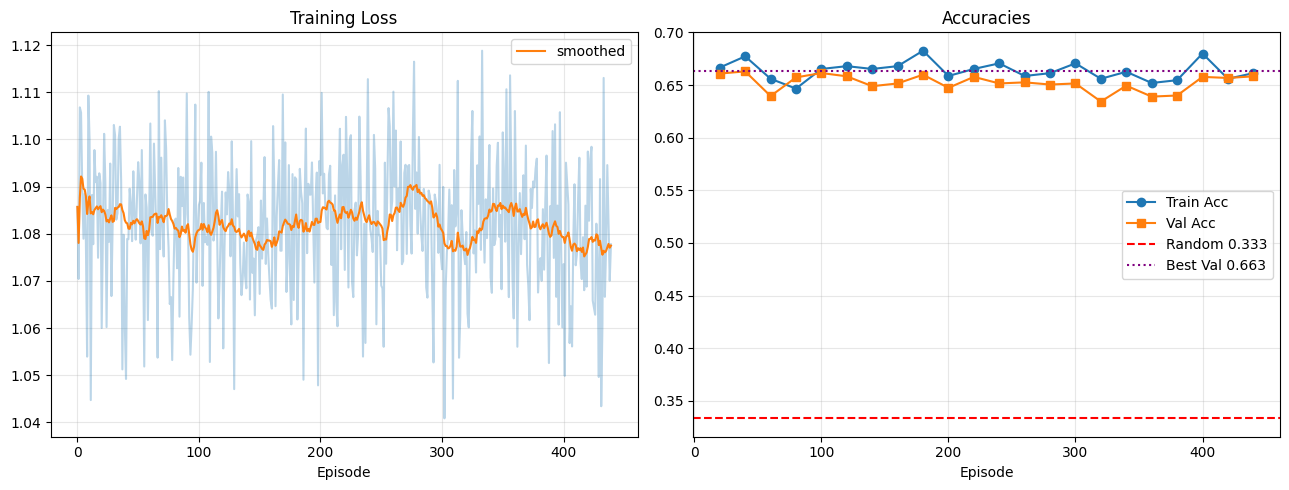

In [26]:
# Cell 14: Training Plots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Loss plot
axes[0].plot(train_losses, alpha=0.3)
axes[0].plot(pd.Series(train_losses).rolling(window=20, min_periods=1).mean(), label="smoothed")
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Episode")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
eval_steps = [i * EVAL_EVERY for i in range(1, len(val_accs) + 1)]
axes[1].plot(eval_steps, train_accs, marker='o', label="Train Acc")
axes[1].plot(eval_steps, val_accs, marker='s', label="Val Acc")
axes[1].axhline(1.0 / N, color='r', linestyle='--', label=f"Random {1.0/N:.3f}")
axes[1].axhline(best_val, color='purple', linestyle=':', label=f"Best Val {best_val:.3f}")
axes[1].set_title("Accuracies")
axes[1].set_xlabel("Episode")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# t-SNE Visualization

In [27]:
# Cell 1: Imports and Configuration
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Configuration
LABEL_COL = "mechanism"
SUBSET_SOURCE = "test"  # {"train","val","test","all"}
TOP_M_CLASSES = 10
N_PER_CLASS = 50
TSNE_PERPLEX = 30
RANDOM_STATE = 42

print("t-SNE Configuration:")
print(f"  Subset source: {SUBSET_SOURCE}")
print(f"  Top M classes: {TOP_M_CLASSES}")
print(f"  Samples per class: {N_PER_CLASS}")
print(f"  t-SNE perplexity: {TSNE_PERPLEX}")

t-SNE Configuration:
  Subset source: test
  Top M classes: 10
  Samples per class: 50
  t-SNE perplexity: 30


In [28]:
# Cell 2: Prepare Subset Data
model.eval()

# Choose base dataframe
base_df = {"train": train_df, "val": val_df, "test": test_df}.get(SUBSET_SOURCE, df)

# Get top M classes by frequency
counts = base_df[LABEL_COL].value_counts()
kept_labels = counts.head(TOP_M_CLASSES).index.tolist()

# Sample N_PER_CLASS from each class
subset_list = []
for lab in kept_labels:
    sub = base_df[base_df[LABEL_COL] == lab]
    if len(sub) > N_PER_CLASS:
        sub = sub.sample(N_PER_CLASS, random_state=RANDOM_STATE)
    subset_list.append(sub)

subset = pd.concat(subset_list).reset_index(drop=True)

print(f"[t-SNE] Using {len(subset)} samples from {SUBSET_SOURCE} across {len(kept_labels)} classes.")
print("Class distribution in subset:")
print(subset[LABEL_COL].value_counts())

[t-SNE] Using 270 samples from test across 10 classes.
Class distribution in subset:
mechanism
Aminoglycoside_O-phosphotransferases     50
Fosfomycin_thiol_transferases            50
Mercury_resistance_protein               46
VanC-type_resistance_protein             45
Multi-drug_RND_efflux_pumps              17
VanB-type_regulator                      17
Drug_and_biocide_MFS_efflux_regulator    13
Mutant_porin_proteins                    13
Quinolone_active_efflux                  10
MDR_regulator                             9
Name: count, dtype: int64


In [29]:
# Cell 3: Encode Subset Data
# Tokenize sequences
ids = [encode_ids(s, KMER_K) for s in subset["sequence"].tolist()]

# Pad sequences
tok = np.full((len(ids), MAX_LEN), stoi[PAD], dtype=np.int64)
for i, seq in enumerate(ids):
    s = seq[:MAX_LEN]
    tok[i, :len(s)] = s

# Prepare numeric features
num = subset[["gc_content", "seq_len"]].to_numpy(np.float32)
num = (num - num_mean) / num_std  # Standardize using train stats

# Get labels
y_str = subset[LABEL_COL].values

print(f"Encoded data shapes:")
print(f"  Tokens: {tok.shape}")
print(f"  Numeric features: {num.shape}")
print(f"  Labels: {y_str.shape}")

Encoded data shapes:
  Tokens: (270, 512)
  Numeric features: (270, 2)
  Labels: (270,)


In [30]:
# Cell 4: Generate Embeddings
with torch.no_grad():
    Xt = torch.from_numpy(tok).long().to(device)
    Xn = torch.from_numpy(num).float().to(device)
    Z = model(Xt, Xn).detach().cpu().numpy()

print(f"Generated embeddings shape: {Z.shape}")
print(f"Embedding dimension: {Z.shape[1]}")

Generated embeddings shape: (270, 256)
Embedding dimension: 256


In [31]:
# Cell 5: Compute t-SNE Transformation
num_points = len(Z)
num_classes = len(np.unique(y_str))
emb_before = Z.shape[1]

# Adjust perplexity if needed
perplexity = min(TSNE_PERPLEX, max(5, len(Z) // 4 - 1))

print(f"Running t-SNE with perplexity={perplexity}...")

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    metric="euclidean",
    init="pca",
    learning_rate="auto",
    n_iter=1000,
    random_state=RANDOM_STATE,
    verbose=1  # Show progress
)

Z2 = tsne.fit_transform(Z)
emb_after = Z2.shape[1]

print(f"t-SNE completed: {Z.shape} -> {Z2.shape}")

Running t-SNE with perplexity=30...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 270 samples in 0.000s...
[t-SNE] Computed neighbors for 270 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 270 / 270
[t-SNE] Mean sigma: 0.347772


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.017506
[t-SNE] KL divergence after 1000 iterations: 0.262798
t-SNE completed: (270, 256) -> (270, 2)


In [32]:
# Cell 6: Compute Evaluation Metrics
# Convert string labels to integers
label_to_int = {lab: i for i, lab in enumerate(kept_labels)}
y_int = np.array([label_to_int.get(v, -1) for v in y_str])

# Silhouette score
sil = silhouette_score(Z2, y_int, metric="euclidean") if num_classes > 1 else float("nan")

# Clustering metrics
kmeans = KMeans(n_clusters=num_classes, n_init="auto", random_state=RANDOM_STATE)
pred = kmeans.fit_predict(Z2)
ari = adjusted_rand_score(y_int, pred)
nmi = normalized_mutual_info_score(y_int, pred)

# Distance metrics
D = pairwise_distances(Z2, metric="euclidean")
intra = [D[i, y_int == y_int[i]].mean() for i in range(num_points)]
inter = [D[i, y_int != y_int[i]].mean() for i in range(num_points)]
mean_intra = float(np.nanmean(intra))
mean_inter = float(np.nanmean(inter))
ratio = (mean_inter / mean_intra) if mean_intra > 0 else float("nan")

print("\n=== t-SNE Diagnostic Summary ===")
print(f"Number of points visualized: {num_points}")
print(f"Number of unique {LABEL_COL}s: {num_classes}")
print(f"Embeddings dimensionality before t-SNE: {emb_before}")
print(f"Embeddings dimensionality after t-SNE: {emb_after}")
print(f"Silhouette score: {sil:.3f}")
print(f"Mean intra-class distance: {mean_intra:.3f}")
print(f"Mean inter-class distance: {mean_inter:.3f}")
print(f"Inter / Intra ratio: {ratio:.3f}")
print(f"ARI (KMeans vs true): {ari:.3f}")
print(f"NMI (KMeans vs true): {nmi:.3f}")
print("================================\n")


=== t-SNE Diagnostic Summary ===
Number of points visualized: 270
Number of unique mechanisms: 10
Embeddings dimensionality before t-SNE: 256
Embeddings dimensionality after t-SNE: 2
Silhouette score: -0.191
Mean intra-class distance: 14.938
Mean inter-class distance: 19.111
Inter / Intra ratio: 1.279
ARI (KMeans vs true): 0.179
NMI (KMeans vs true): 0.353



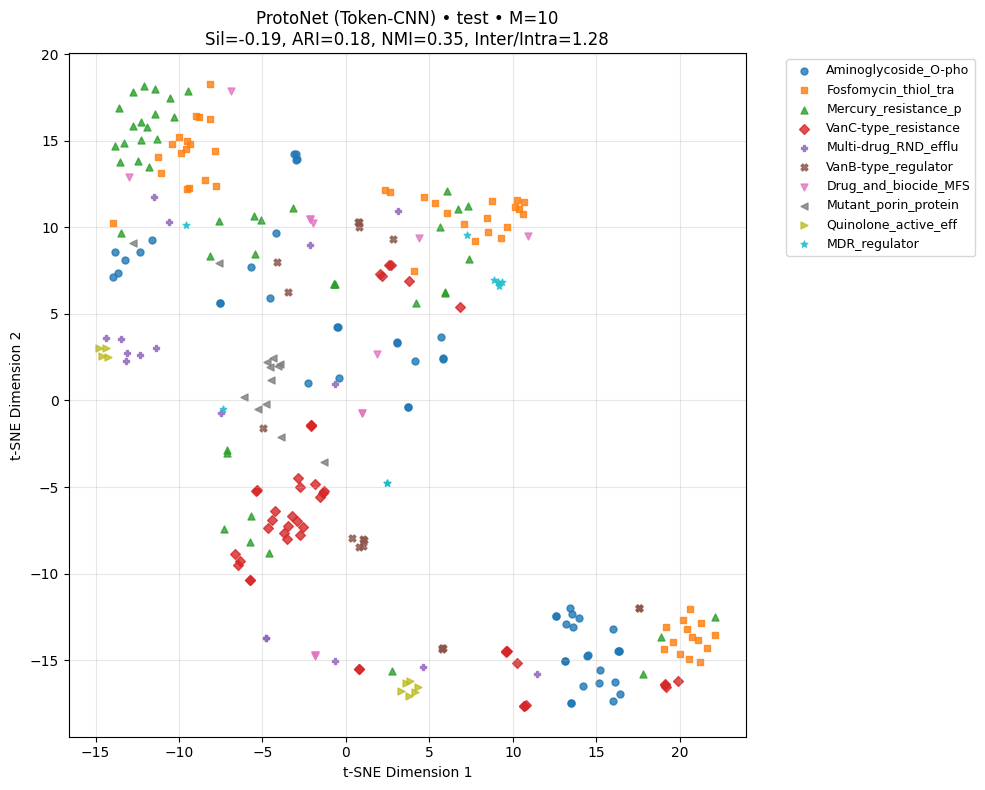

In [33]:
# Cell 7: Create Visualization
plt.figure(figsize=(10, 8))

# Define markers for different classes
markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*"]

# Plot each class with different markers
for i, lab in enumerate(kept_labels):
    idx = (y_str == lab)
    plt.scatter(
        Z2[idx, 0],
        Z2[idx, 1],
        s=25,
        marker=markers[i % len(markers)],
        alpha=0.8,
        label=lab[:20]  # Truncate long labels
    )

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title(
    f"ProtoNet (Token-CNN) • {SUBSET_SOURCE} • M={num_classes}\n"
    f"Sil={sil:.2f}, ARI={ari:.2f}, NMI={nmi:.2f}, Inter/Intra={ratio:.2f}"
)

# Legend outside the plot
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9,
    ncol=1,
    frameon=True,
    fancybox=True,
    framealpha=0.8
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Cell 8: Optional - Save Results
# Save the t-SNE coordinates and labels for later use
tsne_results = pd.DataFrame({
    'tsne_1': Z2[:, 0],
    'tsne_2': Z2[:, 1],
    'label': y_str,
    'label_int': y_int
})

# Add original embeddings
for i in range(min(5, Z.shape[1])):  # Save first 5 dimensions of original embeddings
    tsne_results[f'emb_{i}'] = Z[:, i]

tsne_results.to_csv(f'tsne_results_{SUBSET_SOURCE}.csv', index=False)
print(f"t-SNE results saved to 'tsne_results_{SUBSET_SOURCE}.csv'")

# Print some statistics
print("\nAdditional Statistics:")
print(f"t-SNE variance explained (component 1): {np.var(Z2[:, 0]):.3f}")
print(f"t-SNE variance explained (component 2): {np.var(Z2[:, 1]):.3f}")
print(f"Total variance: {np.var(Z2[:, 0]) + np.var(Z2[:, 1]):.3f}")

t-SNE results saved to 'tsne_results_test.csv'

Additional Statistics:
t-SNE variance explained (component 1): 99.839
t-SNE variance explained (component 2): 127.482
Total variance: 227.321
